# Figure 1. Sex-biased gene expression and alternative splicing. 

- (a) Pre-messenger RNA splicing occurs cotranscriptionally and is influenced by RNA binding proteins and epigenetic factors such as histone modifications that interact with the transcriptional machinery or other proteins to influence splicing and transcription.17 
- (b) Flowchart depicting the analysis of GTEx RNA-seq data. Analysis of GTEx gene expression and AS profiles identified significantly sex-biased genes and AS events. Data were used as input for a hierarchical Bayesian model to characterize the influence of RBPs and gene expression on sex-biased AS events. 
- **(c) Heatplot representing similarity in the fold-changes between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.**

- (d) The five categories of AS events that were investigated in this work <br>(**`SE`**: skipped exon/exon inclusion; **`A3SS/A5SS`**: alternative 3’/5’ splice site; **`MEX`**: mutually exclusive exons; **`RI`**: retained intron). 

- **(e) Number of sex-biased AS events per tissue type.**

A `heatplot` representing similarity in the fold-changes between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues. </b>

## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## Loading dependencies

In [1]:
library(downloader)
library(readr)
library(edgeR)
library(biomaRt)
library(DBI) # v >= 1.1.0 required for biomaRt
library(devtools)
library(yarn)
library(statmod)
library(piggyback)
library(snakecase)
library(stringr)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

Loading required package: limma
Warning message:
“package ‘DBI’ was built under R version 3.6.2”Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdi

## Figure 1c  Heatplot representing similarity in the fold-changes between male and female samples
The values in the heatmap being the correlation between the vectors of fold changes of the tissues.

# Retrieving the GTEx archive

We used the R package [{yarn}](https://bioconductor.org/packages/release/bioc/html/yarn.html) to retrieve the GTEx Biobank data. In order to downloaded the latest GTEx version 8.0 for RNA-seq and genotype data (phs000424.v8.v2), released 2019-08-26, we created a fork of the package's GitHub repository and created a new version of the function **`yarn::downloadGTEx()`**, namely **`yarn::downloadGTExV8()`** to download this release. 

We used the function to perform quality control, gene filtering and normalization pre-processing on the GTEx RNA-seq data, as described in (Paulson et al, 2017). This pipeline tested for sample sex-misidentification, merged related sub-tissues and performed tissue-aware normalization using the **`{yarn::qsmooth}`**  function (Hicks et al, 2017).

We have archived the output of the **`yarn::downloadGTExV8()`** function, which is an `ExpressionSet` object in the repo `lifebitai/lifebitCloudOSDREgtex` for replicability and decreasing the runtime of this analysis. Below we retrieve this `gtex.rds` object from the GitHub releases using the **`{ropensci/piggyback}`** package, but we have also added the relevant command to retrieve the data from GTEx and generate the `ExpressionSet` object using  **`yarn::downloadGTExV8()`**. For the current analysis we are utilising a compute resource with 8 vCPUs and 60 GB of memory available.



In [2]:
# Load with readRDS() if gtex.rds available in data/
if ("gtex.rds" %in% list.files("../data/")) {
    message("Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")   
    obj <- readRDS(file = "../data/gtex.rds")
    message("Done!\n")
    message("Generating sha256sum for gtex.rds ..\n")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")
}

# Download from archive if not available in ../data
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 from GitHub Releases archive into the ../data/ directory ..\n")
    piggyback::pb_download(file = "gtex.rds", 
                                repo = "lifebit-ai/lifebitCloudOSDREgtex", 
                                tag  = "fig1c_archive", 
                                dest = "../data/")
    message("Generating sha256sum for gtex.rds ..")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")    
    message("Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")    
    obj <- readRDS(file = "../data/gtex.rds" )
    message("Done!\n")
}

# Download with yarn if you wish, this requires several minutes to complete
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 with 'yarn::downloadGTExV8()'")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!")

}


Warning message in get_token():
“Using default public GITHUB_TOKEN.
downloading gtex.rds ...                         about 200 Running gh query
Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”

  |======================================================================| 100%


Generating sha256sum for gtex.rds ..
18e2c7a83c98dcf59ddab53e1281923979d49da6ea3acb68114c5a44057c57bc  ../data/gtex.rds
Done!

Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..

Done!



In [3]:
# Confirm that it is an expression set.
# and check the dimensions of the objects, and the phenotype information of the objects
class(obj) 
dim(phenoData(obj))
dim(obj)

[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

rowNames columnNames 
      17384          67

Features  Samples 
   55878    17382

### NOTE: 

We observe above that our phenotype data have 2 more observations than our expression data,  let's inspect what are these samples:

In [4]:
sample_names=as.vector(as.character(colnames(exprs(obj))))
length(sample_names)

pheno_sample_names=as.vector(as.character(rownames(pData(obj))))
length(pheno_sample_names)

if (length(pheno_sample_names) > length(sample_names)) {
    superset <- pheno_sample_names
    subset   <- sample_names    
} 

if (length(pheno_sample_names) < length(sample_names)) {
    superset <- sample_names
    subset   <- pheno_sample_names   
} 

non_overlaps <- setdiff( superset, subset)

message("The non-overlapping IDs between pheno and count data are:\n\n", 
        paste(non_overlaps, collapse = "\n") )

[1] 17382

[1] 17384

The non-overlapping IDs between pheno and count data are:

GTEX-YF7O-2326-101833-SM-5CVN9
GTEX-YEC3-1426-101806-SM-5PNXX


Let's keep only the overlapping IDs:

In [5]:
logical_match_names=pheno_sample_names %in% sample_names
length(logical_match_names)
table(logical_match_names)
pData(obj) <- (pData(obj)[logical_match_names==TRUE,])
dim(pData(obj))
dim(obj)

[1] 17384

logical_match_names
FALSE  TRUE 
    2 17382 

[1] 17382    67

Features  Samples 
   55878    17382

In [8]:
# read in the metadata file for the samples - which links the SRR numbers to the GTEx sample numbers as well as other info

In [10]:
SraRunTable <- read.csv("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt", stringsAsFactors = FALSE)

In [11]:
head(SraRunTable)

,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<lgl>
1,SRR2911715,RNA,RNA-Seq,150,3852895500,PRJNA244100,SAMN04216864,Cloud Testing,HG00103,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
2,SRR2911716,RNA,RNA-Seq,150,4885577400,PRJNA244100,SAMN04216866,Cloud Testing,HG00154,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
3,SRR2911718,RNA,RNA-Seq,150,2690545500,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
4,SRR2911719,RNA,RNA-Seq,150,2699599350,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
5,SRR2911720,RNA,RNA-Seq,152,4300467752,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
6,SRR2911717,RNA,RNA-Seq,150,2666546700,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA


In [12]:
colnames(SraRunTable)

[1] "Run"                              "analyte_type"                    
 [3] "Assay.Type"                       "AvgSpotLen"                      
 [5] "Bases"                            "BioProject"                      
 [7] "BioSample"                        "biospecimen_repository"          
 [9] "biospecimen_repository_sample_id" "body_site"                       
[11] "Bytes"                            "Center.Name"                     
[13] "Consent_Code"                     "Consent"                         
[15] "DATASTORE.filetype"               "DATASTORE.provider"              
[17] "DATASTORE.region"                 "Experiment"                      
[19] "gap_accession"                    "Instrument"                      
[21] "Is_Tumor"                         "Library.Name"                    
[23] "LibraryLayout"                    "LibrarySelection"                
[25] "LibrarySource"                    "Organism"                        
[27] "Platform"                         "ReleaseDate"                     
[29] "Sample.Name"                      "SRA.Study"                       
[31] "study_design"                     "study_name"                      
[33] "submitted_subject_id"             "sex"                             
[35] "AssemblyName"                     "histological_type"               
[37] "molecular_data_type"              "alignment_software..exp."        
[39] "AvgReadLength..run."              "coverage..run."                  
[41] "lsid..exp."                       "lsid..run."                      
[43] "project..exp."                    "project..run."                   
[45] "run_barcode..run."                "run_name..run."                  
[47] "work_request..exp."               "work_request..run."              
[49] "flowcell_barcode..run."           "gssr_id..exp."                   
[51] "gssr_id..run."                    "material_type..exp."             
[53] "read_group_id..run."              "research_project..exp."          
[55] "research_project..run."           "root_sample_id..exp."            
[57] "root_sample_id..run."             "sample_id..exp."                 
[59] "Sample_ID..run."                  "analysis_type..exp."             
[61] "analysis_type..run."              "instrument_name..run."           
[63] "lane..run."                       "library_type..exp."              
[65] "library_type..run."               "sample_type..exp."               
[67] "product_order..exp."              "product_order..run."             
[69] "data_type..exp."                  "data_type..run."                 
[71] "product_part_number..exp."        "product_part_number..run."       
[73] "sample_barcode..exp."             "sample_barcode..run."            
[75] "is_technical_control"             "target_set..exp."                
[77] "primary_disease..exp."            "secondary_accessions..run."      
[79] "Alignment_Provider..run."

In [35]:
install.packages("R.utils")

also installing the dependencies ‘R.oo’, ‘R.methodsS3’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [36]:
library(R.utils)

Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.0 (2020-02-14 07:10:20 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.23.0 successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following object is masked from ‘package:magrittr’:

    equals

The following objects are masked from ‘package:devtools’:

    check, unload

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.9.2 successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings


In [37]:
# We have currently all of our runs from rMATS stored with the SRR number - this maps to the annotation via the SraRunTable$biospecimen_repository_sample_id

In [38]:
se.jc.inc <- data.table::fread("../data/rmats_final.se.jc.inc.txt.gz") 

In [39]:
dim(se.jc.inc)

[1] 42611  8674

In [40]:
head (se.jc.inc)

ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000,0.0000,0.000,0.0000,0.0769,0.0000,0.0000,0,0.0000,⋯,0.0000,0.000,0,0.0,0.0000,0,0.0000,0,0,0
2,1.0000,1.0000,1.000,0.9972,1.0000,1.0000,0.9885,1,1.0000,⋯,1.0000,1.000,1,1.0,1.0000,1,1.0000,1,1,1
3,1.0000,0.0000,1.000,0.0000,0.0000,0.0000,1.0000,1,1.0000,⋯,1.0000,1.000,0,1.0,1.0000,0,1.0000,0,0,0
4,0.0000,1.0000,1.000,0.5000,0.0000,0.0000,1.0000,0,0.5000,⋯,0.0000,0.000,0,0.0,0.2000,0,0.0000,0,0,0
5,1.0000,0.0000,0.250,0.1578,0.4285,1.0000,0.1428,1,0.4545,⋯,0.1428,0.250,0,0.2,0.5000,0,0.5000,0,0,0
6,0.0833,0.0041,0.027,0.0087,0.0142,0.0082,0.0078,0,0.0084,⋯,0.0095,0.037,0,0.0,0.0058,0,0.0078,0,0,0


#  Now we want to replace all *dashes* with **dots "."**

In [17]:
pData(obj)$SAMPID[1]
SraRunTable$biospecimen_repository_sample_id[10]
pData(obj)$SAMPID                            <- gsub('-','\\.',pData(obj)$SAMPID)
SraRunTable$biospecimen_repository_sample_id <- gsub('-','\\.',SraRunTable$biospecimen_repository_sample_id)
pData(obj)$SAMPID[1]
SraRunTable$biospecimen_repository_sample_id[10]


[1] "GTEX.1117F.0226.SM.5GZZ7"

[1] "GTEX-WHSB-2026-SM-3LK6H"

[1] "GTEX.1117F.0226.SM.5GZZ7"

[1] "GTEX.WHSB.2026.SM.3LK6H"

In [7]:
colnames(pData(obj))

[1] "SAMPID"    "SMATSSCR"  "SMCENTER"  "SMPTHNTS"  "SMRIN"     "SMTS"     
 [7] "SMTSD"     "SMUBRID"   "SMTSISCH"  "SMTSPAX"   "SMNABTCH"  "SMNABTCHT"
[13] "SMNABTCHD" "SMGEBTCH"  "SMGEBTCHD" "SMGEBTCHT" "SMAFRZE"   "SMGTC"    
[19] "SME2MPRT"  "SMCHMPRS"  "SMNTRART"  "SMNUMGPS"  "SMMAPRT"   "SMEXNCRT" 
[25] "SM550NRM"  "SMGNSDTC"  "SMUNMPRT"  "SM350NRM"  "SMRDLGTH"  "SMMNCPB"  
[31] "SME1MMRT"  "SMSFLGTH"  "SMESTLBS"  "SMMPPD"    "SMNTERRT"  "SMRRNANM" 
[37] "SMRDTTL"   "SMVQCFL"   "SMMNCV"    "SMTRSCPT"  "SMMPPDPR"  "SMCGLGTH" 
[43] "SMGAPPCT"  "SMUNPDRD"  "SMNTRNRT"  "SMMPUNRT"  "SMEXPEFF"  "SMMPPDUN" 
[49] "SME2MMRT"  "SME2ANTI"  "SMALTALG"  "SME2SNSE"  "SMMFLGTH"  "SME1ANTI" 
[55] "SMSPLTRD"  "SMBSMMRT"  "SME1SNSE"  "SME1PCTS"  "SMRRNART"  "SME1MPRT" 
[61] "SMNUM5CD"  "SMDPMPRT"  "SME2PCTS"  "SUBJID"    "SEX"       "AGE"      
[67] "DTHHRDY"

In [8]:
head(exprs(obj))

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,1,1
ENSG00000227232.5,187,109,143,251,113,139,199,473,286,306,⋯,72,96,136,79,89,86,49,84,34,66
ENSG00000278267.1,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,1,0,0,1,0,0,0,0,0,1,⋯,0,0,1,0,2,2,0,1,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,0,0
ENSG00000268020.3,0,1,0,0,0,1,1,0,1,2,⋯,1,0,0,1,2,0,0,0,1,1


In [25]:
# From SraRunTable
meta.data           <- read.csv("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt", header = T)

# Reform GTEX ids in meta.data$biospecimen_repository_sample_id to match pData$SAMPID
meta.data$SAMPID<- gsub("-","." , meta.data$biospecimen_repository_sample_id)

# Merge the 2 metadata tables by column SAMPID
merged <- merge(meta.data, pData(obj), by = "SAMPID")
dim(merged)

# Write dataframe into .csv file
FILE = paste0('../data/merged_metadata', '.csv')
write.table( merged,
             file      = FILE,
             append    = FALSE,
             quote     = FALSE,
             sep       = ",",
             row.names = F,
             col.names = T)

lung_DTHHRDY_equal_zero          <- merged[(merged$SMTSD == "Lung") & (merged$DTHHRDY == 0), ]
dim(lung_DTHHRDY_equal_zero)

breast                           <- merged[merged$SMTSD == "Breast - Mammary Tissue"  , ]
dim(breast)


[1] 8781  146

[1]   2 146

[1] 206 146

#  Differential Expression using `{edgeR}`

For gene expression analysis, we used the exprs(obj) function to obtain the counts matrix via transcript_counts_matrix <- exprs(obj).  For us we will use the results from our rMATS - first with se.inc.jc.txt but then for all

In [20]:
dim(se.jc.inc)

[1] 42611  7355

In [10]:
dim(transcript_counts_matrix)

[1] 55878 17382

To use the **`edgeR::DGEList()`** function, we need to transpose our `transcript_counts_matrix` so that the length of group is equal to the number of columns in our counts (`transcript_counts_matrix`). You will get an error from the   **`edgeR::DGEList()`** function (counts = x, group = group) if the length of group is not equal to the number of columns in counts.

In [11]:
group <- factor(pData(obj)$SEX)

In [21]:
groupiso <- factor(SraRunTable$sex)

In [12]:
table(group)

group
    1     2 
11584  5798 

In [22]:
table(groupiso)

groupiso
       female   male 
     6   3688   6090 

### NOTE: 

This step takes several minutes to complete. If you have **not** applied other filtering options or you are coming back to your analysis and want to continue from this step, feel free to use the cached version using the following command:

```
# Load with readRDS() if `../data/DGENormFactorsy.rds` available in data/
if ("DGENormFactorsy.rds" %in% list.files("../data/")) {
    message("Loading  `../data/DGENormFactorsy.rds` object with `readRDS()` from ../data/ \n")    
    y <- readRDS("../data/DGENormFactorsy.rds")
    message("Done!")    
}
```

By default, these objects will be regenarated the making sure the changes from above are applied to these objects as well.

In [13]:
# Download if not available in ../data
if (!("DGENormFactorsy.rds" %in% list.files("../data/"))) {
    message("Creating `DGEList` object from counts matrix with 'edgeR::DGEList()' ..")
    y <- edgeR::DGEList(counts = transcript_counts_matrix, 
                        group  = group)
    message("Done!\n")    

    message("Calculating normalization factors on `DGEList` object to scale the raw library sizes with 'edgeR::DGEList()' ..")    
    y <- edgeR::calcNormFactors(y)
    message("Done!\n")    
    message("Saving normalization factors object in '../data/DGENormFactorsy.rds' ..")        
    saveRDS(y, file = "../data/DGENormFactorsy.rds")
    message("Done!\n")    
    message("Generating sha256sum for DGENormFactorsy.rds ..\n")    
    message(system("sha256sum ../data/DGENormFactorsy.rds", intern = TRUE))
    message("Done!\n")
}

attributes(y)

Creating `DGEList` object from counts matrix with 'edgeR::DGEList()' ..
Done!

Calculating normalization factors on `DGEList` object to scale the raw library sizes with 'edgeR::DGEList()' ..
Done!

Saving normalization factors object in '../data/DGENormFactorsy.rds' ..
Done!

Generating sha256sum for DGENormFactorsy.rds ..

1de1314915e6e3112033c100d95da7bebcc829dd6e94d35b2dd00bfb713dec98  ../data/DGENormFactorsy.rds
Done!



$class
[1] "DGEList"
attr(,"package")
[1] "edgeR"

$names
[1] "counts"  "samples"

In [23]:
if (!("DGENormFactors.y.se.jc.inc.rds" %in% list.files("../data"))) {
    y.se.jc.inc <- edgeR::DGEList(counts = se.jc.inc, 
                        group  = groupiso)
    message("Done!\n")    

    message("Calculating normalization factors on `DGEList` object to scale the raw library sizes with 'edgeR::DGEList()' ..")    
    y.se.jc.inc <- edgeR::calcNormFactors(y.se.jc.inc)
    message("Done!\n")    
    message("Saving normalization factors object in '../data/DGENormFactors.y.se.jc.inc.rds' ..")        
    saveRDS(y, file = "../data/DGENormFactors.y.se.jc.inc.rds")
    message("Done!\n")    
    message("Generating sha256sum for DGENormFactors.y.se.jc.inc.rds ..\n")    
    message(system("sha256sum ../data/DGENormFactors.y.se.jc.inc.rds", intern = TRUE))
    message("Done!\n")
}

attributes(y.se.jc.inc)

ERROR: Error in edgeR::DGEList(counts = se.jc.inc, group = groupiso): Length of 'group' must equal number of columns in 'counts'


In [14]:
dim(y$counts)

[1] 55878 17382

In [15]:
# For Guy -- does this do what you are expecting -- I am confused because what you get when you
#        ask for the min (table(groups)) is the smaller sized group -- which in this case is 
#        female -- it will help the reader to know what you are doing here with the statement.
#        one can read what it is doing but not understand your objective.groups <- pData(obj)$SEX
# keep.events <- rep(TRUE, nrow(y))
# for (group in c(1,2)) {
#    keep.events <- keep.events & 
#                   rowSums(cpm(y[,groups %in% group]) > 1) >= 0.25*min(table(groups))
# }

#  From Anne - I believe the objective in this step is to keep only those genes that are in the
#    that are above the threshold of expression for the lower quartile of all sex specific genes.
#    groups = (1,2) -- lots of confusion in logic between groups and group and male and female
#    I recommend we use male and female.
#    two errors then in the above loop - 
#     1. min(table(groups)) will always return the
#        length of the number of samples that are female 
#        (which is 5978 for this v8 GTEx)
#     2. sum(table(group)) will return the number of samples that are either male or female
#        depending upon whether you are in the loop for male or female consideration.

#    If my assumption is true - I recommend replacing it with the following.

#  this should be replaced 


In [42]:
male   <- merged$SEX==1
female <- merged$SEX==2
table(merged$SEX)
table(male)
table(female)

dim(merged)


   1    2 
5579 3202 

male
FALSE  TRUE 
 3202  5579 

female
FALSE  TRUE 
 5579  3202 

[1] 8781  146

In [ ]:
keep.events <- rep(TRUE, nrow(se.jc.inc))
nrow(se.jc.inc)

#
keep.events  <- keep.events & rowSums(edgeR::cpm(y$counts[,group == 1]) > 1) >= 0.25*length(group==1)
#
# now keep all the male subsets or the female subsets meeting our criteria
#
keep.events2 <- keep.events | rowSums(edgeR::cpm(y$counts[,group == 2]) > 1) >= 0.25*length(group==2)
table(keep.events)
table(keep.events2)

In [17]:
# Load with readRDS() if `../data/reduced_y.rds` available in data/
if  ( ('reduced_y.rds' %in% list.files("../data/")) && ('reduced_obj' %in% list.files("../data/"))) {
    message("Loading  `reduced_y.rds` and  `reduced_obj` objects with `readRDS()` from ../data/ \n")    
    reduced_obj <- readRDS(file = "../data/reduced_obj.rds")
    reduced_y   <- readRDS(file = "../data/reduced_y.rds")
    message("Done!")    
}


# Create if not available in ../data
if  ( !(('reduced_y.rds' %in% list.files("../data/")) && ('reduced_obj' %in% list.files("../data/")))) {

    message("Creating `reduced_y` keeping only rows that match `keep.events2` list ..")
    reduced_y<- y[keep.events2,]
    message("Done!\n")    
    
    message("Creating `reduced_obj` keeping only rows that match `keep.events2` list ..")    
    reduced_obj <- obj[keep.events2==TRUE,]
    message("Done!\n")    
    
    message("Saving `reduced_y.rds`, `reduced_obj.rds` in '../data/' ..")        
    saveRDS(reduced_y, file = "../data/reduced_y.rds")
    saveRDS(reduced_obj, file = "../data/reduced_obj.rds")
    message("Done!\n")     
}

dim(reduced_obj)

Creating `reduced_y` keeping only rows that match `keep.events2` list ..
Done!

Creating `reduced_obj` keeping only rows that match `keep.events2` list ..
Done!

Saving `reduced_y.rds`, `reduced_obj.rds` in '../data/' ..
Done!



Features  Samples 
   15895    17382

# Separate the analysis by male and by female


   1    2 
5579 3202 

male
FALSE  TRUE 
 3202  5579 

female
FALSE  TRUE 
 5579  3202 

In [31]:
dim(se.jc.inc)

[1] 42611  7355

In [32]:
dim(merged)

[1] 8781  146

In [20]:
dim(reduced_obj_male)
dim(reduced_obj_female)

Features  Samples 
   15895    11584

Features  Samples 
   15895     5798

In [21]:
# changing from SMTS to SMTSD - more granularity -- but we could produce both figures
tissue_groups_male <- factor(pData(reduced_obj_male)$SMTSD)
tissue_groups_female <- factor(pData(reduced_obj_female)$SMTSD)

In [22]:
# good sanity check, the male set does not have any vaginas or uterus
table (tissue_groups_male)

tissue_groups_male
                   Adipose - Subcutaneous 
                                      445 
             Adipose - Visceral (Omentum) 
                                      371 
                            Adrenal Gland 
                                      157 
                           Artery - Aorta 
                                      279 
                        Artery - Coronary 
                                      146 
                          Artery - Tibial 
                                      454 
                                  Bladder 
                                       14 
                         Brain - Amygdala 
                                      107 
 Brain - Anterior cingulate cortex (BA24) 
                                      128 
          Brain - Caudate (basal ganglia) 
                                      183 
            Brain - Cerebellar Hemisphere 
                                      157 
                       Brain - Cere

In [23]:
# and the females have no prostate or testis
table(tissue_groups_female)

tissue_groups_female
                   Adipose - Subcutaneous 
                                      218 
             Adipose - Visceral (Omentum) 
                                      170 
                            Adrenal Gland 
                                      101 
                           Artery - Aorta 
                                      153 
                        Artery - Coronary 
                                       94 
                          Artery - Tibial 
                                      209 
                                  Bladder 
                                        7 
                         Brain - Amygdala 
                                       45 
 Brain - Anterior cingulate cortex (BA24) 
                                       48 
          Brain - Caudate (basal ganglia) 
                                       63 
            Brain - Cerebellar Hemisphere 
                                       58 
                       Brain - Ce

Reproducing previous results using the `yarn` expression object, loop through the tissues and for those tissues that are shared between the two sexes perform a differential gene analysis on a per tissue basis.


In [24]:
tissue_groups <- factor(pData(reduced_obj)$SMTSD)

In [25]:
tissue_male_female <- tissue_groups_male %in% tissue_groups_female
table(tissue_male_female)

tissue_male_female
FALSE  TRUE 
  606 10978 

In [26]:
tissue_shared_male_female <- factor(tissue_groups_male[tissue_male_female])
table(tissue_shared_male_female)

tissue_shared_male_female
                   Adipose - Subcutaneous 
                                      445 
             Adipose - Visceral (Omentum) 
                                      371 
                            Adrenal Gland 
                                      157 
                           Artery - Aorta 
                                      279 
                        Artery - Coronary 
                                      146 
                          Artery - Tibial 
                                      454 
                                  Bladder 
                                       14 
                         Brain - Amygdala 
                                      107 
 Brain - Anterior cingulate cortex (BA24) 
                                      128 
          Brain - Caudate (basal ganglia) 
                                      183 
            Brain - Cerebellar Hemisphere 
                                      157 
                       Brain

In [27]:
# SEX is coded 1 == Male
#              2 == Female
sex = factor(pData(reduced_obj)$SEX)

Let's now define a function named `fit_tissue()`that accepts two arguments, the `tissue` and an `object` and create the **model matrix** based  that tissue's sex. We will perform a linear fit after calculating normal factors (based on the library size) and calculate the dispersion using `{voom}` (mean variance model of dispersion). We are saving the resulting matrixes as files.


In [28]:
fit_tissue <- function (tissue, obj) {
    tissue_true    <- pData(obj)$SMTSD == tissue
    tissue_obj     <- obj[,tissue_true ==TRUE]
    tissue_sex     <- factor(pData(tissue_obj)$SEX)
    tissue_design  <- model.matrix(~tissue_sex)
    y_tissue       <- DGEList(counts=exprs(tissue_obj), group=tissue_sex)
    y_tissue       <- calcNormFactors(y_tissue)
    y_tissue_voom  <- voom(y_tissue, tissue_design)
    fit_tissue     <- lmFit(y_tissue_voom, tissue_design)
    fit_tissue     <- eBayes(fit_tissue, robust=TRUE)
    results_tissue <- topTable (fit_tissue, coef='tissue_sex2', number=nrow(y_tissue))
    filename = paste(paste("../data",gsub(" ","",tissue), sep="/"),"DGE.csv", sep="_")    
    write.table(results_tissue, filename, sep=',', quote=FALSE)
    return (results_tissue)
}

In [29]:
# debugging with using the 'Thyroid' tissue
#thyroid_logFC <- fit_tissue('Thyroid',reduced_obj)
#thyroid_logFC
# 
all_logFC <- lapply(X=levels(tissue_shared_male_female), FUN=fit_tissue, obj=reduced_obj)

In [30]:
filenames <- list.files("../data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
(filenames)

[1] "../data/Adipose-Subcutaneous_DGE.csv"                
 [2] "../data/Adipose-Visceral(Omentum)_DGE.csv"           
 [3] "../data/AdrenalGland_DGE.csv"                        
 [4] "../data/Artery-Aorta_DGE.csv"                        
 [5] "../data/Artery-Coronary_DGE.csv"                     
 [6] "../data/Artery-Tibial_DGE.csv"                       
 [7] "../data/Bladder_DGE.csv"                             
 [8] "../data/Brain-Amygdala_DGE.csv"                      
 [9] "../data/Brain-Anteriorcingulatecortex(BA24)_DGE.csv" 
[10] "../data/Brain-Caudate(basalganglia)_DGE.csv"         
[11] "../data/Brain-CerebellarHemisphere_DGE.csv"          
[12] "../data/Brain-Cerebellum_DGE.csv"                    
[13] "../data/Brain-Cortex_DGE.csv"                        
[14] "../data/Brain-FrontalCortex(BA9)_DGE.csv"            
[15] "../data/Brain-Hippocampus_DGE.csv"                   
[16] "../data/Brain-Hypothalamus_DGE.csv"                  
[17] "../data/Brain-Nucleusaccumbens(basalganglia)_DGE.csv"
[18] "../data/Brain-Putamen(basalganglia)_DGE.csv"         
[19] "../data/Brain-Spinalcord(cervicalc-1)_DGE.csv"       
[20] "../data/Brain-Substantianigra_DGE.csv"               
[21] "../data/Breast-MammaryTissue_DGE.csv"                
[22] "../data/Cells-Culturedfibroblasts_DGE.csv"           
[23] "../data/Cells-EBV-transformedlymphocytes_DGE.csv"    
[24] "../data/Colon-Sigmoid_DGE.csv"                       
[25] "../data/Colon-Transverse_DGE.csv"                    
[26] "../data/Esophagus-GastroesophagealJunction_DGE.csv"  
[27] "../data/Esophagus-Mucosa_DGE.csv"                    
[28] "../data/Esophagus-Muscularis_DGE.csv"                
[29] "../data/Heart-AtrialAppendage_DGE.csv"               
[30] "../data/Heart-LeftVentricle_DGE.csv"                 
[31] "../data/Kidney-Cortex_DGE.csv"                       
[32] "../data/Kidney-Medulla_DGE.csv"                      
[33] "../data/Liver_DGE.csv"                               
[34] "../data/Lung_DGE.csv"                                
[35] "../data/MinorSalivaryGland_DGE.csv"                  
[36] "../data/Muscle-Skeletal_DGE.csv"                     
[37] "../data/Nerve-Tibial_DGE.csv"                        
[38] "../data/Pancreas_DGE.csv"                            
[39] "../data/Pituitary_DGE.csv"                           
[40] "../data/Skin-NotSunExposed(Suprapubic)_DGE.csv"      
[41] "../data/Skin-SunExposed(Lowerleg)_DGE.csv"           
[42] "../data/SmallIntestine-TerminalIleum_DGE.csv"        
[43] "../data/Spleen_DGE.csv"                              
[44] "../data/Stomach_DGE.csv"                             
[45] "../data/Thyroid_DGE.csv"                             
[46] "../data/WholeBlood_DGE.csv"

In [31]:
# preserve the ordered rownames for later assignment to matrix
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 

In [32]:
# Make a matrix for each of the tissues
# from what files are saved

make_tissue_matrix_ready <- function (file, obj) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.csv(filename)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),nrow=dim(obj)[2],ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}

In [33]:
matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready, obj=reduced_obj)

In [34]:
length(matrix_list)
logFC_mat = as.matrix(lapply(X   = matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj)[2], 
                      ncol = length(matrix_list))
length(logFC_mat)

[1] 46

[1] 46

In [35]:
get_tissue_name <- function (tissue_name) {
            tissue <- str_replace(tissue_name,'_DGE.txt','')
            return(tissue)
}

In [36]:
tissue_list <- lapply(X=levels(tissue_shared_male_female), FUN=get_tissue_name)
length(tissue_list)
head(tissue_list)

[1] 46

[[1]]
[1] "Adipose - Subcutaneous"

[[2]]
[1] "Adipose - Visceral (Omentum)"

[[3]]
[1] "Adrenal Gland"

[[4]]
[1] "Artery - Aorta"

[[5]]
[1] "Artery - Coronary"

[[6]]
[1] "Artery - Tibial"

In [37]:
logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]),nrow=dim(reduced_obj)[2], ncol=1))

for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]),nrow=dim(reduced_obj)[2], ncol=1))
    logFC_mat = cbind(logFC_mat, n)
}

dim(logFC_mat)
rownames(logFC_mat) = logFC_mat_rownames
colnames(logFC_mat) = tissue_list
head(logFC_mat)

[1] 15895    46

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
ENSG00000000003.14,0.159867956,-0.054390442,-0.001420062,0.01910579,0.055831994,0.01975686,0.03369222,0.037372370,-0.05653552,0.01459946,⋯,-0.003767259,0.076920723,-0.29786285,-0.057271529,0.07130993,0.152350904,-0.014153064,0.043080117,-0.083539471,0.14002859
ENSG00000000419.12,-0.015111798,0.054725155,0.029764670,0.01092628,0.036753966,0.01059017,-0.04660812,-0.001611315,0.02301793,0.06902469,⋯,-0.001930505,-0.022461103,-0.05328584,0.005487066,0.05605845,-0.007142621,0.005660932,-0.055294508,-0.012258786,0.14732442
ENSG00000000457.13,0.009501953,0.001604707,-0.044547080,0.02654465,0.001420152,0.07241408,0.01623332,0.069141796,0.06588816,0.03153251,⋯,-0.016295587,-0.008384726,0.04280993,-0.035631149,-0.06907719,0.022458670,0.031778550,-0.007238725,0.023054013,0.18745209
ENSG00000000460.16,-0.036024716,0.016972717,0.015813767,0.04380547,-0.030048709,0.03885698,-0.07443956,0.036740174,0.06604508,-0.01706688,⋯,-0.015547288,0.017757642,0.06010527,0.012014626,-0.04743994,0.056236812,0.075831554,-0.017456828,0.053498280,0.01243589
ENSG00000000938.12,0.371970973,0.133928403,-0.178667703,0.11281414,-0.005249730,0.02795555,0.23602905,0.194845873,0.20882122,0.33196655,⋯,0.178659024,-0.309908157,0.03900437,0.256315471,0.33101095,-0.008547992,-0.114185714,0.032198632,0.152990274,0.06422003
ENSG00000000971.15,0.101369591,-0.052725628,0.215478378,0.01473135,-0.118761119,-0.08043895,-0.15960934,0.286809636,0.12973142,0.25777970,⋯,0.032645652,-0.174701746,0.02503865,0.247245406,0.28298039,-0.365205249,-0.004167090,0.033286928,0.007787418,-0.19620740


In [38]:
logFC_mat_NQ <- normalizeQuantiles(logFC_mat)

In [39]:
head(logFC_mat_NQ)

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
ENSG00000000003.14,0.18163856,-0.057699749,-0.002561785,0.03100612,0.0671783351,0.02962109,0.02421133,0.0414066450,-0.07948192,0.009461349,⋯,-0.007560889,0.12859512,-0.20844639,-0.068721403,0.09323422,0.16301173,-0.016072268,0.071045424,-0.124524045,0.109587317
ENSG00000000419.12,-0.01290889,0.072514519,0.036283839,0.01793584,0.0416967915,0.01572716,-0.02702430,-0.0005564463,0.02096841,0.081626002,⋯,-0.003155334,-0.03289401,-0.05493662,0.003479065,0.07420289,-0.01129464,0.009315197,-0.096737082,-0.021242066,0.116820740
ENSG00000000457.13,0.01753074,0.007059282,-0.054765500,0.04220573,0.0003125237,0.12100082,0.01288429,0.0755805325,0.07373944,0.032011415,⋯,-0.036807183,-0.01040080,0.05439554,-0.044553550,-0.09598508,0.02152593,0.041177680,-0.009562226,0.029252925,0.159291298
ENSG00000000460.16,-0.03704866,0.025192776,0.018491241,0.06727793,-0.0331672748,0.05999445,-0.04329810,0.0408642805,0.07391683,-0.028678481,⋯,-0.035249020,0.03213168,0.07909456,0.010959443,-0.06915861,0.05783887,0.099170937,-0.027087795,0.070267301,0.002878269
ENSG00000000938.12,0.40449005,0.183163005,-0.234672498,0.14864390,-0.0067902018,0.04212011,0.15156786,0.2121257423,0.26199942,0.413599973,⋯,0.344435114,-0.37680111,0.04905316,0.311078523,0.37250988,-0.01303658,-0.146072512,0.054242144,0.186963834,0.042745248
ENSG00000000971.15,0.12194223,-0.056092042,0.243680747,0.02400421,-0.1206659800,-0.09712891,-0.09392522,0.3355878654,0.15231143,0.306434374,⋯,0.075144397,-0.22330161,0.03107249,0.300366927,0.32556092,-0.40784357,-0.003512847,0.055919787,0.008558994,-0.216267208


In [40]:
dist_mat <- as.matrix(cor(logFC_mat_NQ))

In [41]:
head(dist_mat)

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
Adipose - Subcutaneous,1.0000000,0.8365272,0.7440858,0.8033718,0.7970331,0.8053699,0.8231428,0.7739447,0.7843509,0.7867614,⋯,0.8650933,0.7583434,0.7764261,0.8086684,0.8132758,0.8384233,0.7820020,0.8116124,0.8479777,0.7859629
Adipose - Visceral (Omentum),0.8365272,1.0000000,0.7807381,0.7840836,0.8462510,0.8220345,0.8159421,0.7563617,0.7623832,0.7814339,⋯,0.8200249,0.7763044,0.7703798,0.8054233,0.8102348,0.8240124,0.7958134,0.7946560,0.8242039,0.7790460
Adrenal Gland,0.7440858,0.7807381,1.0000000,0.8007187,0.8291998,0.7873730,0.7711136,0.7459315,0.7454137,0.7447619,⋯,0.7647180,0.8304141,0.7528460,0.7532003,0.7575763,0.7812392,0.8224205,0.7992741,0.7598380,0.7694753
Artery - Aorta,0.8033718,0.7840836,0.8007187,1.0000000,0.8620546,0.8465083,0.7943843,0.7737738,0.7845717,0.7753456,⋯,0.8113718,0.7865932,0.7611948,0.7810575,0.7804755,0.7861684,0.7920763,0.8156777,0.8001367,0.7968146
Artery - Coronary,0.7970331,0.8462510,0.8291998,0.8620546,1.0000000,0.8724207,0.7847650,0.7530278,0.7585706,0.7692536,⋯,0.7987615,0.8127769,0.7682309,0.8066411,0.8146596,0.8146890,0.8147805,0.8007671,0.7817212,0.8061614
Artery - Tibial,0.8053699,0.8220345,0.7873730,0.8465083,0.8724207,1.0000000,0.7852306,0.7644496,0.7636510,0.7685798,⋯,0.8512421,0.8203590,0.7970638,0.8221117,0.8230303,0.8054339,0.7998696,0.8230236,0.8059742,0.7988171


In [42]:
rownames(dist_mat) <- colnames(logFC_mat)
colnames(dist_mat) <- colnames(logFC_mat)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/dist_mat.rds")
message("Done!")

Saving dist_mat object
Done!


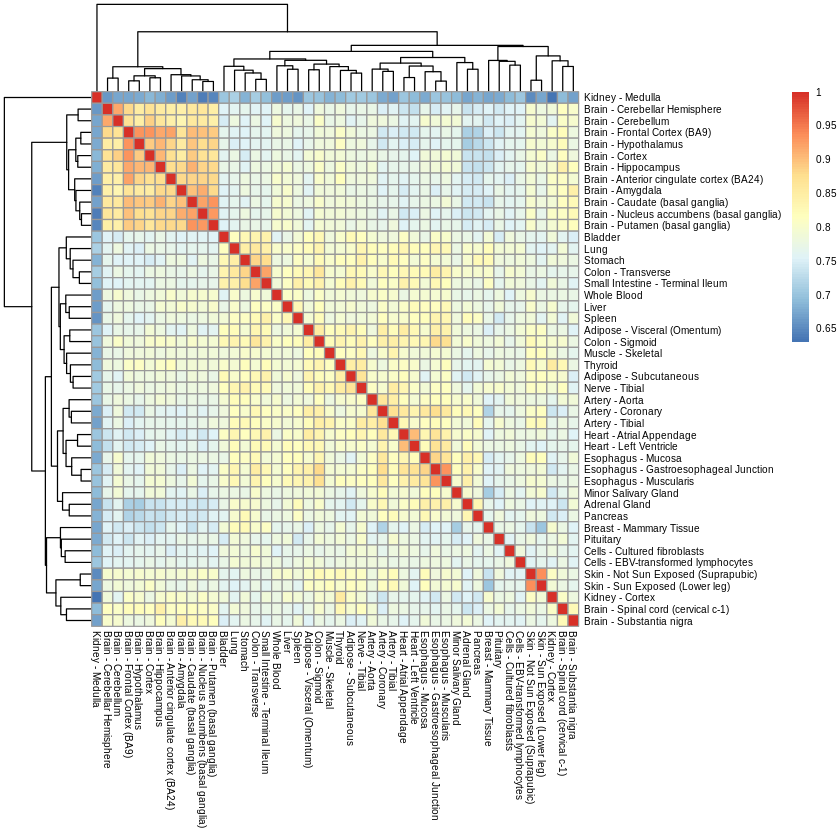

In [43]:
library(pheatmap)
pheatmap(as.matrix(dist_mat),   fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/Figure1c.pdf"))

## Figure 1e - Number of sex-biased AS events per tissue type.

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”

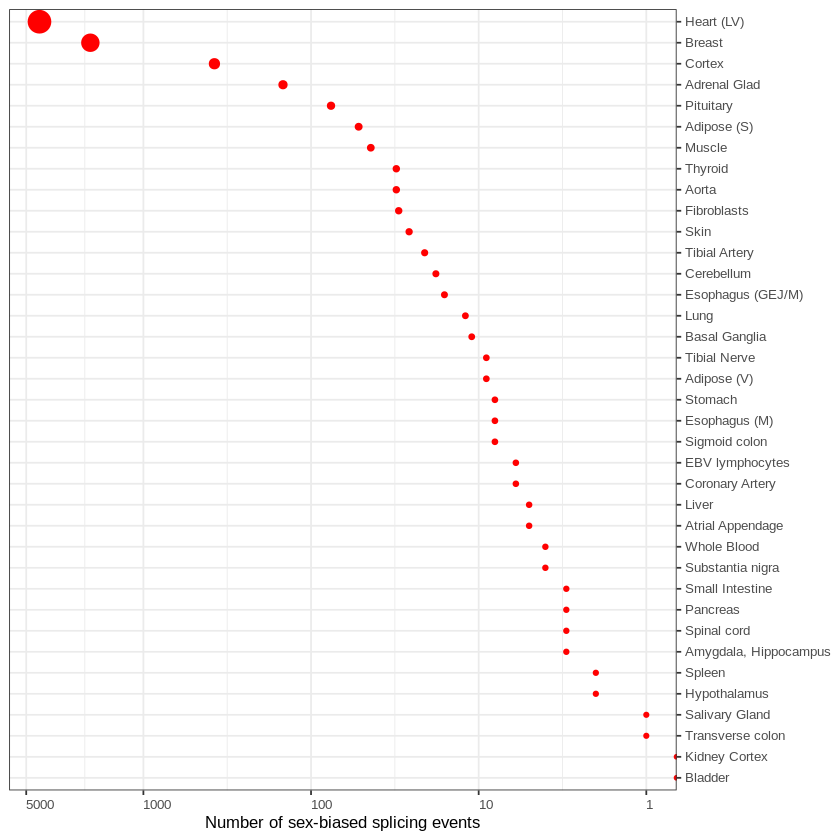

In [44]:
totals <- read.table("../dimorphAS/figures/figure1/Totals_by_tissue_annotated.txt", sep = "\t", quote = NULL, header = T)
totals_s <- totals %>% arrange(Total)
totals_s$Label <- factor(totals_s$Label, levels = totals_s$Label)


## Function to get a reverse log10 scale on the x axis
reverselog_trans <- function(base = exp(1)) {
  trans <- function(x) -log(x, base)
  inv <- function(x) base^(-x)
  trans_new(paste0("reverselog-", format(base)), trans, inv, 
            log_breaks(base = base), 
            domain = c(1e-100, Inf))
}



g<-ggplot(totals_s, aes(y = Label, x = Total, size = Total)) +
  geom_point(color = "red") +
  theme_bw() +
  scale_x_continuous(trans=reverselog_trans(), breaks=c(1,10,100,1000,5000,10000)) +#breaks=c(10000, 5000,1000,100,10,1)) +
  scale_y_discrete(position = "right") +
  theme(axis.text.x = element_text(size=8, angle = 0, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=8),
        axis.title.x = element_text(face="plain", colour="black", 
                                    size=10),
        axis.title.y = element_blank(),
        legend.title=element_blank(),
        legend.text = element_text(face="plain", colour="black", 
                                   size=8)) +
  xlab(paste("Number of sex-biased splicing events")) +
  ylab("Tissue") + 
  guides(size=FALSE)

g
ggsave("figure1e.pdf",g, height = 4.5, width = 4)

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [66]:
figure_id   = "figure1"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
2c22da474cfcf3e0f2eed020b22d11b32192d92a483d185ff90738622204babf,./reduced_obj.rds
2b4e03c09d1b0faf96ca24c347a10d7cdfe9eef7c40b2615d8de01b1fd820670,./dist_mat.rds
18e2c7a83c98dcf59ddab53e1281923979d49da6ea3acb68114c5a44057c57bc,./gtex.rds
58dede0438acb2c7ce3d5bb1e1bdf0dae82ab4ab725cdbfb6a080c23b63f7b16,./csv.tar.gz
1de1314915e6e3112033c100d95da7bebcc829dd6e94d35b2dd00bfb713dec98,./DGENormFactorsy.rds
be53124f034b2e33e0868604b2ff8f8864af7427a39127229de888cb9b12420a,./reduced_y.rds
5146c849c9354129590c59da5e6040a074523b4827d0975e3f5fa43737af7e9a,./README.md


### 2. Libraries metadata

In [67]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-03-10                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
biomaRt,biomaRt,2.42.0,2.42.0,/opt/conda/lib/R/library/biomaRt,/opt/conda/lib/R/library/biomaRt,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
DBI,DBI,1.1.0,1.1.0,/opt/conda/lib/R/library/DBI,/opt/conda/lib/R/library/DBI,TRUE,FALSE,2019-12-15,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
devtools,devtools,2.0.2,2.0.2,/opt/conda/lib/R/library/devtools,/opt/conda/lib/R/library/devtools,TRUE,FALSE,2019-04-08,CRAN (R 3.6.0),NA,/opt/conda/lib/R/library
downloader,downloader,0.4,0.4,/opt/conda/lib/R/library/downloader,/opt/conda/lib/R/library/downloader,TRUE,FALSE,2015-07-09,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
